## Author: Ritvik Kharkar

In [1]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint
from random import random
import matplotlib.pyplot as plt
from time import time

In [2]:
def calculate_lambda_at_t_val(params, lambda_0, F, T_vals, t):
    """
    INPUTS:
        params: ((k+1,)) parameters. First k are alpha then delta
        lambda_0: the baseline lambda
        F: (N x k) features
        T_vals: (N x 1) event times
        t: real number, current time stamp
        lambda_0: the baseline event intensity
    
    OUTPUT:
        value of the lambda function at t
    """
    
    #get alpha and delta
    alpha = params[:-1].reshape(-1,1)
    delta = params[-1]
    
    #create the event times mask
    mask = (T_vals <= t)
    
    #get the T vals which are before the current time
    T_vals_lim = T_vals[mask]
    
    #get the features which are before the current time
    F_lim = F[mask]
    
    #get sum of weighted features
    weights_lim = np.exp(delta * T_vals_lim)
    sum_weighted_features_lim = (weights_lim * F_lim).sum(axis=0).reshape(-1,1)
    
    #get weighted alpha
    weighted_alpha = (alpha * np.exp(-delta * t)).reshape(-1,1)
    
    #compute dot product
    lambda_val = lambda_0 + (sum_weighted_features_lim * weighted_alpha).sum()
        
    #return final lambda value
    return lambda_val

In [3]:
def calculate_lambda_at_T_vals(params, lambda_0, F, T_vals):
    """
    INPUTS:
        params: ((k+1,)) parameters. First k are alpha then delta
        lambda_0: the baseline lambda
        F: (N x k) features
        T_vals: (N x 1) event times
        lambda_0: real number, baseline event intensity
    
    OUTPUT:
        value of the lambda function at each t in T_vals, (N x 1)
    """
    
    #get alpha and delta
    alpha = params[:-1].reshape(-1,1)
    delta = params[-1]
    
    #get the weighted scores
    weights = np.exp(delta * T_vals)
    weighted_scores = F * weights
    
    #get cumulative sum of weighted scores
    cumul_sum_weighted_scores = np.cumsum(weighted_scores, axis=0)
    
    #get the weighted alpha
    weighted_alpha = np.transpose(alpha) * (1/weights)
    
    #get elementwise product and sum each row
    lambda_vals = lambda_0 + (weighted_alpha * cumul_sum_weighted_scores).sum(axis=1).reshape(-1,1)
    
    #return the lambda_values
    return lambda_vals

In [4]:
def calculate_neg_log_likelihood(params, lambda_0, T_vals, diagnostics=False):
    """
    INPUTS:
        params: ((k+1,)) parameters. First k are alpha and then delta
        lambda_0: the baseline lambda
        T_vals: ((N+1) x 1) event times
    
    OUTPUT:
        value of the negative log likelihood function
    """
    
    #get alpha and delta and lambda_0
    alpha = params[0]
    delta = params[-1]
    
    #get weights
    weights = np.exp(delta*T_vals)
    
    #get inverse weights
    inv_weights = 1 / weights
    
    #get difference between inverse weights
    diff_inv_weights = inv_weights[:-1] - inv_weights[1:]
    
    #get cumulative sum of weights
    cumul_sum_weights_inc_first = np.cumsum(weights)[:-1].reshape(-1,1)
    cumul_sum_weights_not_inc_first = np.cumsum(weights)[1:].reshape(-1,1)
    
    #calculate the sum term
    sum_term = np.sum(np.log(lambda_0*np.ones_like(diff_inv_weights) + alpha*inv_weights[1:]*cumul_sum_weights_not_inc_first))
    
    #calculate the integral term 
    integral_term = lambda_0*T_vals[-1][0] + (alpha / delta) * np.sum(cumul_sum_weights_inc_first * diff_inv_weights)
    
    if diagnostics:
        print('Sum Term: %s'%sum_term)
        print('Integral Term: %s'%integral_term)
        
        print('inv_weights: \n%s'%inv_weights[1:])
        print('cumul_sum_weights_not_inc_first: \n%s'%cumul_sum_weights_not_inc_first)
        print('elementwise product: \n%s'%(inv_weights[1:]*cumul_sum_weights_not_inc_first))
        print('inside log: \n%s'%(lambda_0 + alpha*inv_weights[1:]*cumul_sum_weights_not_inc_first))
    
    #return total negative log likelihood
    return integral_term - sum_term

In [5]:
def simulate_hawkes_process(params, lambda_0, T_vals, F, dt, T, viz=True, single_event=False):
    """
    INPUTS:
        params: ((k+1,)) parameters. First k are alpha then delta
        lambda_0: the baseline lambda
        F: (1 x k) first feature
        T_vals: (1 x 1) first event time
        dt: real number, step size during simulation
        T: end time of simulation
        lambda_0: the baseline event intensity
        viz: boolean for whether we want to display a graph or not
        
        
    OUTPUTS (in order):
        T_vals: final times of all events
        F: final features
    """
    
    #create list of lambda vals for viz
    lambda_vals = []
    
    #create list of time vals for viz
    time_vals = []
    
    #create list of event times for viz
    event_times = []
    
    #get the current time as the first passed in event
    curr_time = T_vals[-1][0] + dt
    
    #while we haven't yet reached out final time
    while curr_time < T:
        
        #append this time val to a list for viz
        time_vals.append(curr_time)
        
        #get the probability that we have an event right now
        lambda_val = calculate_lambda_at_t_val(params, lambda_0, F, T_vals, curr_time)
        prob = lambda_val * dt
        
        #append this lambda val to a list for viz
        lambda_vals.append(lambda_val)
        
        #if we meet that probability, then add an event to the data
        if random() < prob:
            event_times.append(curr_time)
            T_vals = np.concatenate([T_vals, [[curr_time]]], axis=0)
            F = np.concatenate([F, [[1]]], axis=0)
            if single_event:
                return event_times[0]
        
        #increment current time
        curr_time += dt
        
    #return right away if no viz
    if not viz:
        return T_vals, F
    
    #otherwise there is viz
    plt.figure(figsize=(10,6))
    plt.plot(time_vals, lambda_vals)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('lambda (event intensity)', fontsize=16)

    for t in event_times:
        plt.axvline(t, color='k', linestyle='--', alpha=.5)
        
    return T_vals, F

In [6]:
def generate_random_params():
    alpha = 1 - np.random.random()
    delta = np.random.random()
    return np.array([alpha, delta])

In [7]:
def get_recovered_params(T_vals, num_starts, true_params, lambda_0, dev_level=0.1):
    """
    This function starts the minimization process from many random starting points and returns the recovered params
    """
    
    #set the constraints on the params
    A_1 = np.array([[1,1], [0,1], [-1,0]])
    constraint_1 = LinearConstraint(A_1, 0, np.inf)
    
    recovered_params = []
    
    for _ in range(num_starts):
        
        #get starting params
        params_init = generate_random_params()

        try:
            #get recoverd params
            result = minimize(calculate_neg_log_likelihood, x0=params_init, args=(lambda_0, T_vals), method='COBYLA', \
                              constraints=[{'type': 'ineq', 'fun': lambda x: -x[0]},
                                           {'type': 'ineq', 'fun': lambda x: x[1]},
                                           {'type': 'ineq', 'fun': lambda x: x[0] + x[1]}])
            
            if result.success == True:
                recovered_params.append(result.x)
        
        except ValueError as v:
            print(v)
                
    return np.array(recovered_params)

In [8]:
def get_missing_param(true_params, lambda_0, T_vals, channel_name=''):
    
    t1_start = time()

    for idx in range(true_params.shape[0]):
        
        var = 'alpha' if idx == 0 else 'delta'
        
        param_vals = np.arange(0,1,.01) if var=='delta' else np.arange(-1,0,.01)
        
        losses = np.empty_like(param_vals)
        
        min_pair = [-1,99999999]

        for i in range(param_vals.shape[0]):
            p_copy = true_params.copy()
            p_copy[idx] = param_vals[i]
            losses[i] = calculate_neg_log_likelihood(p_copy, lambda_0, T_vals)
            if losses[i] < min_pair[1]:
                min_pair[0] = param_vals[i]
                min_pair[1] = losses[i]
        
        plt.plot(param_vals, losses)
        plt.title('%s\nTrue Value: %s\nLoss Min Param: %s\nLoss: %s'%(var, true_params[idx], round(min_pair[0],2), round(min_pair[1],2)), fontsize=16)
        plt.xlabel(var, fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.tight_layout()
        plt.show()
        plt.savefig('%s_one_const_var=%s_lambda0=%s_alpha=%s_delta=%s.png'%(channel_name, var, lambda_0, true_params[0], true_params[1]))
        plt.clf()
        #print('Best %s: %s'%(var, round(min_pair[0],2)))
        
    t1_end = time()
    #print('One-Param Time: %s'%(t1_end-t1_start))
        
    #whole grid search
    
    t2_start = time()

    alpha_vals = np.arange(-1,0,.01)

    delta_vals = np.arange(0,1,.01)

    min_params = [-1,-1, 99999999]
    
    points = []

    for alpha in alpha_vals:
        for delta in delta_vals:
            if delta + alpha > 0:
                loss = calculate_neg_log_likelihood(np.array([alpha, delta]), lambda_0, T_vals)
                if not np.isnan(loss):
                    points.append((alpha, delta, loss))
                if loss < min_params[-1]:
                    min_params = [alpha, delta, loss]

    print('Whole Grid Result: %s'%min_params)
    
    t2_end = time()
    
    plt.figure(figsize=(8,8))
    losses = [i[2] for i in points]
    min_loss = min(losses)
    max_loss = max(losses)
    #print('Min Loss: %s'%min_loss)
    #print('Max Loss: %s'%max_loss)
    losses = [(i - min_loss) / (max_loss - min_loss) for i in losses]
    colors = [(l,l,l) for l in losses]
    
    plt.scatter([i[0] for i in points], [i[1] for i in points], color=colors, s=10)
    plt.axvline(min_params[0], color='r', linestyle='--', alpha=0.75)
    plt.axhline(min_params[1], color='r', linestyle='--', alpha=0.75)
    
    plt.title('Grid Search Results:\nalpha=%s, delta=%s'%(round(min_params[0],2), round(min_params[1],2)), fontsize=18)
    plt.xlabel('alpha', fontsize=16)
    plt.ylabel('delta', fontsize=16)
    
    plt.tight_layout()
    plt.savefig('%s_grid_search_lambda_0=%s_alpha=%s_delta=%s.png'%(channel_name, lambda_0, true_params[0], true_params[1]))
    
    #print('Grid Search Time: %s'%(t2_end-t2_start))
    
    return min_params

In [9]:
def get_next_event_times(T_vals, lambda_0, params, num_sims=1000):
    next_event_times = []
    F_init = np.ones_like(T_vals)
    for _ in range(num_sims): 
        next_event_time = simulate_hawkes_process(recovered_params, lambda_0, T_vals, F_init, .01, 10000000, viz=False, single_event=True)
        next_event_times.append(next_event_time)
    return next_event_times

In [10]:
def simulate_future_event(T_vals, limit, lambda_0, params, num_sims, channel_name):
    num_included = len(T_vals[T_vals < limit]) + 1
    next_event_times = get_next_event_times(T_vals[:num_included].reshape(-1,1), lambda_0, params, num_sims)
    
    plt.figure(figsize=(8,4))
    avg = round(np.mean(next_event_times), 2)
    dev = round(np.std(next_event_times), 2)
    true = round(T_vals[num_included][0],2 )
    plt.hist(next_event_times, color='cornflowerblue', edgecolor='black', linewidth=2, density=True)
    plt.axvline(avg, alpha=0.75, linestyle='--', color='r')
    plt.axvline(true, alpha=0.75, color='b')
    plt.ylabel('Density', fontsize=16)
    plt.xlabel('Predicted Next Event Time', fontsize=16)
    plt.title('%s - After t=%s days\nAvg. Pred=%s days\nDev. Pred=%s days\nTrue Event Time=%s days'%(channel_name, limit, avg, dev, true), fontsize=20)
    
    plt.tight_layout()
    
    plt.savefig('%s_%sdays_prediction.png'%(channel_name, limit))

## Simulation

Avg Gap: 1.0598936170214261
Dev Gap: 0.9108640913650471
Num Events: 95


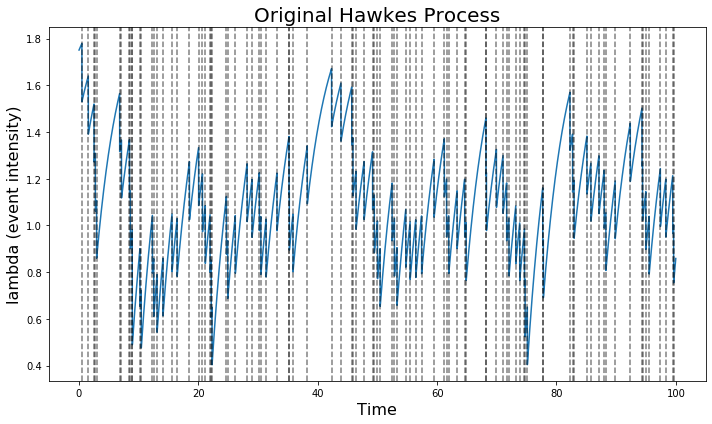

In [12]:

T_vals_init = np.array([0]).reshape((1,1))
F_init = np.ones((1,1))
lambda_0 = 2
true_params = np.array([-.25, .25])
T_vals_final, F_final = simulate_hawkes_process(true_params, lambda_0, T_vals_init, F_init, .01, 100, viz=True)

gaps = np.diff(T_vals_final.reshape(1,-1))

print('Avg Gap:', np.mean(gaps))
print('Dev Gap:', np.std(gaps))
print('Num Events:', len(T_vals_final))

plt.title('Original Hawkes Process', fontsize=20)

plt.tight_layout()

# Get Real Data

In [13]:
channel_name_to_events_list = eval("{'Allrecipes': [0.0, 97.51666666666667, 119.0, 167.18333333333334, 242.25, 309.9166666666667, 335.0, 357.0, 383.0, 434.51666666666665, 456.98333333333335, 503.1333333333333, 527.0, 552.45, 623.5666666666667, 647.35, 671.0, 695.0, 788.6, 819.0166666666667, 839.0, 866.85, 887.0, 912.0666666666667, 935.4833333333333, 987.2166666666667, 1008.6, 1055.3833333333334, 1086.5, 1107.3666666666666, 1153.75, 1175.25, 1226.3333333333333, 1252.15, 1280.2333333333333, 1295.1333333333334, 1343.0, 1401.0333333333333, 1415.0, 1439.0, 1463.2666666666667, 1487.35, 1511.0, 1591.9166666666667, 1610.2166666666667, 1700.0666666666666, 1727.1333333333334, 1756.0, 1774.0, 1825.95, 1848.8666666666666, 1872.2666666666667, 1895.2333333333333, 1918.0, 1947.9666666666667, 1967.0, 2015.0], 'Binging with Babish': [0.0, 120.0, 457.25, 504.0, 624.0, 792.0, 960.0, 1008.0, 1128.0, 1296.0, 1344.0, 1464.0, 1538.0, 1632.0, 1680.0, 1800.0, 1967.0, 2015.5, 2135.0, 2186.0, 2303.0, 2471.0, 2519.0, 2639.0, 2687.0, 2807.383333333333, 2876.0, 2975.25, 3023.0, 3143.0, 3191.0, 3311.0, 3359.0, 3479.0, 3528.5, 3647.0, 3695.0, 3806.233333333333], 'Tasty': [0.0, 77.5, 98.5, 121.25, 148.0, 151.0, 168.0, 172.0, 192.0, 196.0, 220.0, 241.0, 289.0, 292.0, 313.0, 336.0, 340.0, 361.0, 364.0, 385.0, 409.0, 433.0, 457.0, 480.0, 504.0, 508.23333333333335, 519.5, 529.0, 532.0, 553.0, 577.0, 601.0, 602.5166666666667, 602.5333333333333, 602.5333333333333, 602.5333333333333, 625.0, 649.0, 652.0, 672.0, 676.0, 696.0, 700.0, 745.0, 769.0, 793.0, 817.0, 840.0, 846.1333333333333, 864.0, 865.0, 939.0, 940.0333333333333, 964.0, 1008.0, 1015.0, 1032.0, 1033.0, 1132.0, 1157.0, 1176.0, 1200.0, 1228.0, 1249.0, 1324.0, 1348.5, 1372.0, 1396.0, 1468.5, 1513.0, 1540.5, 1562.0, 1613.0]}")

In [14]:
allrecipes_T_vals = np.array(channel_name_to_events_list['Allrecipes']).reshape((-1,1)) / 24
tasty_T_vals = np.array(channel_name_to_events_list['Tasty']).reshape((-1,1)) / 24
babish_T_vals = np.array(channel_name_to_events_list['Binging with Babish']).reshape((-1,1)) / 24

## Try to recover params - COBYLA

In [20]:
lambda_0 = 1

num_trials = 1000

start = time()
result = get_recovered_params(allrecipes_T_vals, num_trials, true_params, lambda_0, .5)
end = time()
print('Avg Milliseconds: %s'%str((end - start)/num_trials*1000))

print('Success Rate:', len(result) / num_trials)

print('Avg Recoverd Params:', result.mean(axis=0))

C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log


Avg Milliseconds: 2.268974781036377
Success Rate: 0.742
Avg Recoverd Params: [5.49742859e-18 2.16824314e+00]


## Grid Search and One-Held Constant

In [21]:
lambda_0 = 1
true_params = np.array([-0.15, 0.15])

C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log


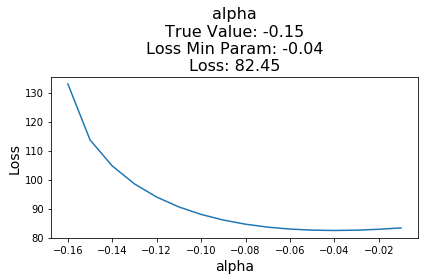

C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


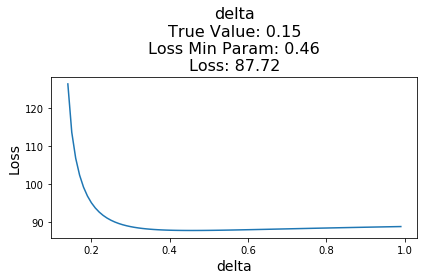

Whole Grid Result: [-0.01999999999999913, 0.05, 81.61189724617728]


<Figure size 432x288 with 0 Axes>

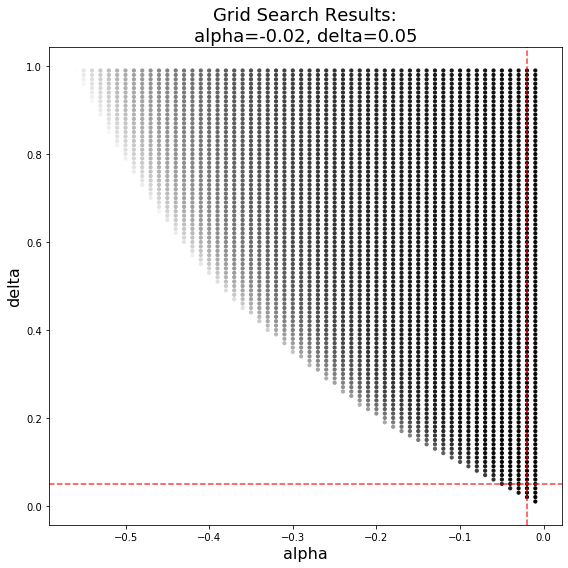

In [22]:
result = get_missing_param(true_params, lambda_0, allrecipes_T_vals, 'allrecipes')

## Simulate with Recovered Params

Avg Gap: 1.34
Dev Gap: 1.23
Num Events: 63


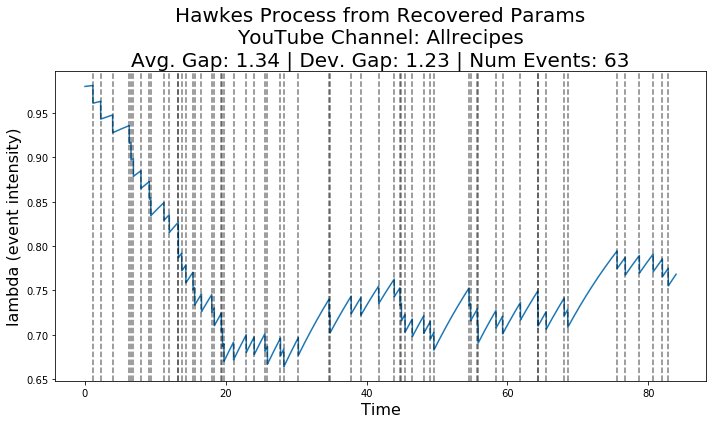

In [24]:
T_vals_init = np.array([0]).reshape((1,1))
F_init = np.ones((1,1))
recovered_params = np.array([-.02, .05])
T_vals_final, F_final = simulate_hawkes_process(recovered_params, lambda_0, T_vals_init, F_init, .01, allrecipes_T_vals[-1][0], viz=True)

gaps = np.diff(T_vals_final.reshape(1,-1))

avg_gap = round(np.mean(gaps), 2)
dev_gap = round(np.std(gaps), 2)
num_events = len(T_vals_final)

print('Avg Gap:', avg_gap)
print('Dev Gap:', dev_gap)
print('Num Events:', num_events)
plt.title('Hawkes Process from Recovered Params\nYouTube Channel: Allrecipes\nAvg. Gap: %s | Dev. Gap: %s | Num Events: %s'%(avg_gap, dev_gap, num_events), fontsize=20)
plt.tight_layout()